# 1. 신용점수 결측치 대체

In [ ]:
!pip install missingpy
!pip install imblearn

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import random

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import sklearn.neighbors._base
import sys
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base

import warnings
warnings.filterwarnings('ignore')
#imputation
from missingpy import MissForest
from sklearn.impute import KNNImputer
#imbalance
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.model_selection import StratifiedKFold

from imblearn.over_sampling import SMOTENC
#model
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier as RF

from sklearn.inear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier as RF

from catboost import CatBoostClassifier
#scoring
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import mean_squared_error

### 데이터 불러오기

In [ ]:
data=pd.read_csv('./merge전처리.csv',encoding='utf-8')
user=pd.read_csv('./user전처리.csv',encoding='utf-8')
user.isnull().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 968727 entries, 0 to 968726
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype
---  ------             --------------   -----
 0   application_id     968727 non-null  bool 
 1   user_id            968727 non-null  bool 
 2   gender             968727 non-null  bool 
 3   insert_time        968727 non-null  bool 
 4   credit_score       968727 non-null  bool 
 5   yearly_income      968727 non-null  bool 
 6   income_type        968727 non-null  bool 
 7   employment_type    968727 non-null  bool 
 8   houseown_type      968727 non-null  bool 
 9   desired_amount     968727 non-null  bool 
 10  purpose            968727 non-null  bool 
 11  existing_loan_cnt  968727 non-null  bool 
 12  existing_loan_amt  968727 non-null  bool 
 13  age                968727 non-null  bool 
 14  work_year          968727 non-null  bool 
 15  rehabilitation     968727 non-null  bool 
 16  product_per_app    968727 non-null  bo

In [ ]:
no_na = user.loc[-user['credit_score'].isnull(),]
no_na.isnull().sum()

application_id       0
user_id              0
gender               0
insert_time          0
credit_score         0
yearly_income        0
income_type          0
employment_type      0
houseown_type        0
desired_amount       0
purpose              0
existing_loan_cnt    0
existing_loan_amt    0
age                  0
work_year            0
rehabilitation       0
product_per_app      0
loan_per             0
dtype: int64

In [ ]:
### 신용점수 대체에 필요없는 변수 제거
no_na = no_na.drop(['application_id','user_id','insert_time'],axis=1)
no_na.shape

(886959, 15)

#### 데이터가 매우 커 전체 데이터에서 비교 불가.  
#### 따라서 80000개의 표본을 추출하며, 이 안에서 임의로 결측치를 부여하여 결측치 대체 방법 간 성능을 비교한다.

In [ ]:
#임의로 80000개의 샘플을 추출한다. 
no_na = no_na.iloc[random.sample(list(np.arange(len(no_na))),80000),:]
no_na.reset_index(drop=True,inplace=True)
no_na.head()

,gender,credit_score,yearly_income,income_type,employment_type,houseown_type,desired_amount,purpose,existing_loan_cnt,existing_loan_amt,age,work_year,rehabilitation,product_per_app,loan_per
0,1,830.0,36000000.0,EARNEDINCOME,정규직,전월세,15000000.0,생활비,2,34000000.0,40대,N년차,알 수 없음,62,대출3회
1,1,890.0,40000000.0,EARNEDINCOME,정규직,전월세,40000000.0,생활비,3,29000000.0,30대,N년차,해당없음,49,대출3회
2,1,800.0,36000000.0,EARNEDINCOME,기타,자가,20000000.0,생활비,4,124000000.0,50대,N년차,해당없음,39,대출신청다수
3,0,780.0,100000000.0,FREELANCER,기타,자가,70000000.0,생활비,1,0.0,50대,N년차,해당없음,10,대출3회
4,1,670.0,35000000.0,OTHERINCOME,기타,자가,20000000.0,기타,3,380000000.0,60대,기타,해당없음,3,대출안함


In [ ]:
#답지 만들기
answer1 = no_na.copy()
answer2 = no_na.copy()
answer3 = no_na.copy()

#교차검증할 데이터 생성
minidata1 = no_na.copy()
minidata2 = no_na.copy()
minidata3 = no_na.copy()

In [ ]:
#모델은 숫자밖에 인식하지 못하므로 인코딩을 통해 범주를 숫자로 변환

encoder = OrdinalEncoder()
# 카테고리 변수
cat_cols = ['gender','income_type','employment_type','houseown_type',
           'purpose','age','rehabilitation','work_year','loan_per']
           
#변수 인코딩 함수 지정
def encode(data):
    #retains only non-null values
    nonulls = np.array(data.dropna())
    #reshapes the data for encoding
    impute_reshape = nonulls.reshape(-1,1)
    #encode date
    impute_ordinal = encoder.fit_transform(impute_reshape)
    #Assign back encoded values to non-null values
    data.loc[data.notnull()] = np.squeeze(impute_ordinal)
    return data

for columns in cat_cols:
    encode(minidata1[columns])
for columns in cat_cols:
    encode(minidata2[columns])
for columns in cat_cols:
    encode(minidata3[columns])

In [ ]:
# 신용점수에 임의로 결측치 부여
na_idx = np.random.choice(np.arange(len(answer1)),
                          size=8000, replace=False)
minidata1.iloc[na_idx,1]=np.nan
minidata2.iloc[na_idx,1]=np.nan
minidata3.iloc[na_idx,1]=np.nan

## Missing Forest

In [ ]:
# 인코딩을 통해 숫자로 만든 변수들에 범주형 타입을 다시 부여하여 범주형 변수로 만든다
minidata1['income_type'] = minidata1.income_type.astype('category')
minidata1['gender'] = minidata1.gender.astype('category')
minidata1['employment_type'] = minidata1.employment_type.astype('category')
minidata1['houseown_type'] = minidata1.houseown_type.astype('category')
minidata1['purpose'] = minidata1.purpose.astype('category')
minidata1['age'] = minidata1.age.astype('category')
minidata1['rehabilitation'] = minidata1.rehabilitation.astype('category')
minidata1['work_year'] = minidata1.work_year.astype('category')
minidata1['loan_per'] = minidata1.loan_per.astype('category')

minidata2['income_type'] = minidata2.income_type.astype('category')
minidata2['gender'] = minidata2.gender.astype('category')
minidata2['employment_type'] = minidata2.employment_type.astype('category')
minidata2['houseown_type'] = minidata2.houseown_type.astype('category')
minidata2['purpose'] = minidata2.purpose.astype('category')
minidata2['age'] = minidata2.age.astype('category')
minidata2['rehabilitation'] = minidata2.rehabilitation.astype('category')
minidata2['work_year'] = minidata2.work_year.astype('category')
minidata2['loan_per'] = minidata2.loan_per.astype('category')

minidata3['income_type'] = minidata3.income_type.astype('category')
minidata3['gender'] = minidata3.gender.astype('category')
minidata3['employment_type'] = minidata3.employment_type.astype('category')
minidata3['houseown_type'] = minidata3.houseown_type.astype('category')
minidata3['purpose'] = minidata3.purpose.astype('category')
minidata3['age'] = minidata3.age.astype('category')
minidata3['rehabilitation'] = minidata3.rehabilitation.astype('category')
minidata3['work_year'] = minidata3.work_year.astype('category')
minidata3['loan_per'] = minidata3.loan_per.astype('category')

In [ ]:
# missingforest 알고리즘 적용 함수

def mf_all(x,y):
    score = pd.DataFrame(columns=['1st','2nd','3rd'])
    cat_cols = [minidata1.columns.get_loc(col) for col in minidata1.select_dtypes(['category']).columns.tolist()]
    for i in x:
        for j in y:
            imputer1 = MissForest(max_iter=i, n_estimators=j, oob_score=True)
            imputed = imputer1.fit_transform(minidata1, cat_vars=cat_cols)
            imputed1 = pd.DataFrame(imputed, columns=minidata1.columns)
            imputer2 = MissForest(max_iter=i, n_estimators=j, oob_score=True)
            imputed = imputer2.fit_transform(minidata2, cat_vars=cat_cols)
            imputed2 = pd.DataFrame(imputed, columns=minidata2.columns)
            imputer3 = MissForest(oob_score=True)
            imputed = imputer3.fit_transform(minidata3, cat_vars=cat_cols)
            imputed3 = pd.DataFrame(imputed, columns=minidata3.columns)
            
            RMSE1 = []
            imp = [imputed1,imputed2,imputed3]
            ans = [answer1,answer2,answer3]
            for k in range(3):
                RMSE1.append(mean_squared_error(ans[k].iloc[na_idx,1],
                              imp[k].iloc[na_idx,1])**0.5)
            score = score.append(pd.DataFrame(np.array(RMSE1).reshape(1,3),columns=['1st','2nd','3rd']))
    return(score)

In [ ]:
# 하이퍼 파라미터 지정하여 실행
x=[3,5,7]
y=[150,200]

score = mf_all(x,y).copy()

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


In [ ]:
#최종점수 및 최고점수
print(score.mean(axis=1))
score

0    73.417481
0    73.210071
0    73.329512
0    73.201431
0    73.228989
0    73.222472
dtype: float64


,1st,2nd,3rd
0,73.429154,73.322209,73.50108
0,73.026032,73.235561,73.368619
0,73.189483,73.323245,73.47581
0,73.123522,73.146509,73.334263
0,73.299008,73.105948,73.282012
0,73.046848,73.198209,73.422359


## KNN imputation

In [ ]:
# 정규화로 변수 간 scale을 맞춰주어 거리계산에 용이하게 만든다
# 범주형 변수들은 더미변수화를 통해 연속형 변수와 거리 scale을 맞춰준다
transformer = StandardScaler()
x_data1 = minidata1[['product_per_app','credit_score','existing_loan_amt',
                     'yearly_income','desired_amount','existing_loan_cnt']]
transformer.fit(x_data1) 
x_data1 = transformer.transform(x_data1)
x_data1 = pd.DataFrame(x_data1,columns=['product_per_app','credit_score','existing_loan_amt','yearly_income','desired_amount','existing_loan_cnt'])
a1 = pd.get_dummies(minidata1[['income_type','gender','employment_type','houseown_type',
                               'purpose','age','rehabilitation',
                               'work_year','loan_per']]).reset_index(drop=True)
x_data1 = pd.concat([x_data1,a1],axis=1)

x_data2 = minidata2[['product_per_app','credit_score','existing_loan_amt',
                     'yearly_income','desired_amount','existing_loan_cnt']]
transformer.fit(x_data2) 
x_data2 = transformer.transform(x_data2)
x_data2 = pd.DataFrame(x_data2,columns=['product_per_app','credit_score','existing_loan_amt','yearly_income','desired_amount','existing_loan_cnt'])
a1 = pd.get_dummies(minidata2[['income_type','gender','employment_type','houseown_type',
                               'purpose','age','rehabilitation',
                               'work_year','loan_per']]).reset_index(drop=True)
x_data2 = pd.concat([x_data2,a1],axis=1)

x_data3 = minidata3[['product_per_app','credit_score','existing_loan_amt',
                     'yearly_income','desired_amount','existing_loan_cnt']]
transformer.fit(x_data3) 
x_data3 = transformer.transform(x_data3)
x_data3 = pd.DataFrame(x_data3,columns=['product_per_app','credit_score','existing_loan_amt','yearly_income','desired_amount','existing_loan_cnt'])
a1 = pd.get_dummies(minidata3[['income_type','gender','employment_type','houseown_type',
                               'purpose','age','rehabilitation',
                               'work_year','loan_per']]).reset_index(drop=True)
x_data3 = pd.concat([x_data3,a1],axis=1)
x_data3.head()

,product_per_app,credit_score,existing_loan_amt,yearly_income,desired_amount,existing_loan_cnt,income_type_0.0,income_type_1.0,income_type_2.0,income_type_3.0,...,rehabilitation_3.0,work_year_0.0,work_year_1.0,work_year_2.0,work_year_3.0,loan_per_0.0,loan_per_1.0,loan_per_2.0,loan_per_3.0,loan_per_4.0
0,3.168395,1.364775,-0.303422,-0.073274,-0.097952,-0.511334,1,0,0,0,...,0,0,1,0,0,0,1,0,0,0
1,2.318372,1.890669,-0.358288,-0.036476,0.029871,-0.261229,1,0,0,0,...,1,0,1,0,0,0,1,0,0,0
2,1.664508,1.101829,0.684173,-0.073274,-0.072388,-0.011123,1,0,0,0,...,1,0,1,0,0,0,0,1,0,0
3,-0.231698,0.926531,-0.676513,0.515486,0.183259,-0.761440,0,0,1,0,...,1,0,1,0,0,0,1,0,0,0
4,-0.689402,-0.037607,3.493332,-0.082473,-0.072388,-0.261229,0,0,0,1,...,1,0,0,1,0,0,0,0,1,0


In [ ]:
def KNN_impute(k):
    score = pd.DataFrame(columns=['1st','2nd','3rd'])
    for i in k:
        imputer=KNNImputer(n_neighbors=i)
        mini_result1 = pd.DataFrame(imputer.fit_transform(x_data1),columns = x_data1.columns)
        mini_result1 = pd.DataFrame(transformer.inverse_transform(mini_result1.iloc[:,:6]),
                                    columns = x_data1.columns[:6])
        mse1 = mini_result1.iloc[na_idx,1]

        mini_result2 = pd.DataFrame(imputer.fit_transform(x_data2),columns = x_data1.columns)
        mini_result2 = pd.DataFrame(transformer.inverse_transform(mini_result2.iloc[:,:6]),
                                    columns = x_data1.columns[:6])
        mse2 = mini_result2.iloc[na_idx,1]
        
        mini_result3 = pd.DataFrame(imputer.fit_transform(x_data3),columns = x_data3.columns)
        mini_result3 = pd.DataFrame(transformer.inverse_transform(mini_result3.iloc[:,:6]),
                                    columns = x_data3.columns[:6])
        mse3 = mini_result3.iloc[na_idx,1]
        
        mses = [mse1 , mse2, mse3]
        ans = [answer1.iloc[na_idx,1], answer2.iloc[na_idx,1], answer3.iloc[na_idx,1]]
        RMSE1 = []
        
        for j in range(3):
            RMSE1.append(mean_squared_error(ans[j], mses[j])**0.5)
            
        score = score.append(pd.DataFrame(np.array(RMSE1).reshape(1,3),columns=['1st','2nd','3rd']))
    return(score)        

In [ ]:
k=[5,9,11]
score2 = KNN_impute(k).copy()

# 최종 점수 
print(score2.mean(axis=1).min())
score2

81.43182071905204


,1st,2nd,3rd
0,83.294772,83.294772,83.294772
0,81.506256,81.506256,81.506256
0,81.431821,81.431821,81.431821


#### missforest : 73.2
#### Knn-imputate : 81.4
#### Lasso (R에서 실행) : 78.31

## 최종 결과로 missforest선정 및 대체

In [ ]:
# 원 데이터 신용점수 결측치 대체
user_1 = user.drop(['application_id','user_id','insert_time'],axis=1)

cat_cols = ['gender','income_type','employment_type','houseown_type',
           'purpose','age','rehabilitation','work_year','loan_per']

for columns in cat_cols:
    encode(user_1[columns])

user_1['income_type'] = user_1.income_type.astype('category')
user_1['gender'] = user_1.gender.astype('category')
user_1['employment_type'] = user_1.employment_type.astype('category')
user_1['houseown_type'] = user_1.houseown_type.astype('category')
user_1['purpose'] = user_1.purpose.astype('category')
user_1['age'] = user_1.age.astype('category')
user_1['rehabilitation'] = user_1.rehabilitation.astype('category')
user_1['work_year'] = user_1.work_year.astype('category')
user_1['loan_per'] = user_1.loan_per.astype('category')


imputer_final = MissForest(max_iter=5, n_estimators=200, oob_score=True)
imputed = imputer_final.fit_transform(user_1, cat_vars=cat_cols)

,gender,credit_score,yearly_income,income_type,employment_type,houseown_type,desired_amount,purpose,existing_loan_cnt,existing_loan_amt,age,work_year,rehabilitation,product_per_app,loan_per
0,1.0,870.0,30000000.0,5.0,3.0,0.0,30000000.0,1.0,1,27000000.0,3.0,1.0,3.0,12,3.0
1,1.0,710.0,30000000.0,2.0,1.0,0.0,10000000.0,3.0,5,15000000.0,0.0,1.0,3.0,11,3.0
2,1.0,820.0,62000000.0,0.0,3.0,2.0,2000000.0,3.0,7,344000000.0,1.0,1.0,3.0,25,0.0
3,1.0,630.0,36000000.0,0.0,3.0,0.0,5000000.0,3.0,1,16000000.0,0.0,1.0,3.0,2,1.0
4,1.0,590.0,45000000.0,3.0,1.0,2.0,15000000.0,1.0,1,20000000.0,2.0,2.0,3.0,1,2.0


In [ ]:
# 최종 대체
cat_cols = [user_1.columns.get_loc(col) for col in user_1.select_dtypes(['category']).columns.tolist()]

imputer_final = MissForest(max_iter=5, n_estimators=200, oob_score=True)
imputed = imputer_final.fit_transform(user_1, cat_vars=cat_cols)

Iteration: 0
Iteration: 1
Iteration: 2


In [ ]:
imputed_final = pd.DataFrame(imputed,columns=user_1.columns)
imputed_final['application_id']=user.application_id
aaaa = imputed_final[['application_id','credit_score']]
final = pd.merge(data.drop(['credit_score'],axis=1),aaaa, on='application_id', how='left')

#데이터 저장
final.to_csv('/Users/user/Downloads/final_data1.csv')

In [ ]:
final_user = pd.merge(user.drop(['credit_score'],axis=1),
                      imputed_final[['application_id','credit_score']], on='application_id', how='left')
final_user.shape

(968727, 18)

In [ ]:
final_user.to_csv('/Users/user/Downloads/final_user.csv')

# 2. 모델링

## 모델링 전 불균형 처리
1) SMOTE 기법 (oversampling)  
2) Class_weight 부여

In [ ]:
# 데이터 불러오기
data1=pd.read_csv('/Users/user/Downloads/final_data1.csv',encoding='utf-8')

## 1) SMOTE

In [ ]:
data1.isnull().sum()

Unnamed: 0                     0
application_id                 0
user_id                        0
gender                         0
insert_time                    0
yearly_income                  0
income_type                    0
employment_type                0
houseown_type                  0
desired_amount                 0
purpose                        0
existing_loan_cnt              0
existing_loan_amt              0
age                            0
work_year                      0
rehabilitation                 0
loanapply_insert_time          0
bank_id                        0
product_id                     0
loan_limit                     0
loan_rate                      0
is_applied               3255482
rate_rank                      0
product_per_app                0
loan_per                       0
credit_score                   0
dtype: int64

In [ ]:
data = data1.drop(['Unnamed: 0','bank_id','product_id',
           'application_id','user_id','insert_time',
          'loanapply_insert_time'],axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13519868 entries, 0 to 13519867
Data columns (total 19 columns):
 #   Column             Dtype  
---  ------             -----  
 0   gender             object 
 1   yearly_income      float64
 2   income_type        object 
 3   employment_type    object 
 4   houseown_type      object 
 5   desired_amount     float64
 6   purpose            object 
 7   existing_loan_cnt  int64  
 8   existing_loan_amt  float64
 9   age                object 
 10  work_year          object 
 11  rehabilitation     object 
 12  loan_limit         float64
 13  loan_rate          float64
 14  is_applied         float64
 15  rate_rank          int64  
 16  product_per_app    int64  
 17  loan_per           object 
 18  credit_score       float64
dtypes: float64(7), int64(3), object(9)
memory usage: 1.9+ GB


In [ ]:
# 데이터 분할
test = data.loc[data['is_applied'].isnull(),]
train = data.loc[-data['is_applied'].isnull(),]

#### 불균형 처리 방식에 따른 모델 별 최적의 하이퍼 파라미터를 찾기 위해 임의로 신청여부에 결측을 만든다
#### 전체 데이터에서 약 10만개의 표본을 추출한다

In [ ]:
# 전체 데이터에서 1퍼센트(10만개) 만 가져오기
X = train.drop(['is_applied'],axis=1)
Y = train['is_applied']
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.01,stratify=Y,random_state=1007)

In [ ]:
#smote 하기 전 정규화
x_train = x_test.copy()

scaler = StandardScaler()
scaler.fit_transform(x_train[['yearly_income','desired_amount','existing_loan_cnt','existing_loan_amt',
                             'loan_limit','loan_rate','rate_rank','product_per_app','credit_score']])
X_train = scaler.fit_transform(x_train[['yearly_income','desired_amount','existing_loan_cnt','existing_loan_amt',
                             'loan_limit','loan_rate','rate_rank','product_per_app','credit_score']])
X_train = pd.DataFrame(X_train,columns=['yearly_income','desired_amount','existing_loan_cnt','existing_loan_amt',
                             'loan_limit','loan_rate','rate_rank','product_per_app','credit_score'])

aa = x_train[['gender','employment_type','houseown_type',
            'age','work_year','rehabilitation','income_type',
            'purpose','loan_per']].reset_index(drop=True)

X_train = pd.concat([X_train,aa],axis=1)

In [ ]:
X_train.head()

,yearly_income,desired_amount,existing_loan_cnt,existing_loan_amt,loan_limit,loan_rate,rate_rank,product_per_app,credit_score,gender,employment_type,houseown_type,age,work_year,rehabilitation,income_type,purpose,loan_per
0,0.012688,-0.134101,-0.271219,0.155280,0.830118,0.448970,-0.649894,-1.161931,-0.531228,1,기타,자가,50대,N년차,해당없음,FREELANCER,대환대출,대출신청다수
1,-0.102106,-0.186741,-0.271219,-0.298933,0.451559,-0.323114,-0.649894,-0.088893,0.420634,1,정규직,전월세,40대,0년차,해당없음,EARNEDINCOME,전월세보증금,대출신청다수
2,0.306845,1.809547,-0.582492,-0.188149,1.208677,-1.841547,-0.934802,0.930493,0.420634,1,정규직,전월세,30대,N년차,알 수 없음,EARNEDINCOME,주택구입,대출안함
3,-0.059058,-0.211037,1.285145,1.373901,-0.197398,0.783540,-0.436213,-1.000975,-1.165802,1,정규직,자가,40대,N년차,알 수 없음,EARNEDINCOME,생활비,대출신청다수
4,-0.137978,-0.150298,0.973872,-0.376482,0.181160,0.037192,0.489738,0.501278,0.024025,1,정규직,기타가족소유,60대,N년차,알 수 없음,EARNEDINCOME,대환대출,대출신청다수


In [ ]:
# 10만개 샘플에서 stratified kfold 하기

X = X_train.copy().reset_index(drop=True)
Y = y_test.copy().reset_index(drop=True)

# split 개수, 셔플 여부 및 seed 설정
str_kf = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 1008)

train_idx = []
test_idx = []

# split 개수 스텝 만큼 train, test 데이터셋을 매번 분할
for train_index, test_index in str_kf.split(X, Y):
    train_idx.append(train_index)
    test_idx.append(test_index)
    

In [ ]:
# smote는 테스트 데이터엔 적용할 수 없으므로 다 따로 빼야함
Y1 = pd.DataFrame(Y)

x_train1 = X.iloc[train_idx[0],:]
x_train2 = X.iloc[train_idx[1],:]
x_train3 = X.iloc[train_idx[2],:]

y_train1 = np.array(Y1.iloc[train_idx[0],:])
y_train2 = np.array(Y1.iloc[train_idx[1],:])
y_train3 = np.array(Y1.iloc[train_idx[2],:])

x_test1 = X.iloc[test_idx[0],:]
x_test2 = X.iloc[test_idx[1],:]
x_test3 = X.iloc[test_idx[2],:]

y_test1 = np.array(Y1.iloc[test_idx[0],:])
y_test2 = np.array(Y1.iloc[test_idx[1],:])
y_test3 = np.array(Y1.iloc[test_idx[2],:])

#### smote

In [ ]:
#범주형 변수 지정
cat_cols = [x_train1.columns.get_loc(col) for col in x_train1.select_dtypes(['object']).columns.tolist()]

#smote 함수 지정
smote = SMOTENC(categorical_features=cat_cols, random_state=1008, n_jobs=-1)


# train데이터를 넣어 복제함
X_resampled1, y_resampled1 = smote.fit_resample(x_train1,y_train1)

print('After OverSampling, the shape of train_X: {}'.format(X_resampled1.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(X_resampled1.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_resampled1==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_resampled1==0)))

X_resampled2, y_resampled2 = smote.fit_resample(x_train2,y_train2)
X_resampled3, y_resampled3 = smote.fit_resample(x_train3,y_train3) #잘 된것을 확인가능

After OverSampling, the shape of train_X: (129462, 18)
After OverSampling, the shape of train_y: (129462, 18) 

After OverSampling, counts of label '1': 64731
After OverSampling, counts of label '0': 64731


#### RandomForest with Smote

In [ ]:
# 미리 catboost데이터 나눠두기
catb_train1 = X_resampled1.copy()
catb_train2 = X_resampled2.copy()
catb_train3 = X_resampled3.copy()

catb_test1 = x_test1.copy()
catb_test2 = x_test2.copy()
catb_test3 = x_test3.copy()

In [ ]:
encoder = OrdinalEncoder()

cat_cols = ['gender','employment_type','houseown_type',
            'age','work_year','rehabilitation','income_type',
            'purpose','loan_per']

for columns in cat_cols:
    encode(X_resampled1[columns])
for columns in cat_cols:
    encode(X_resampled2[columns])
for columns in cat_cols:
    encode(X_resampled3[columns])
for columns in cat_cols:
    encode(x_test1[columns])
for columns in cat_cols:
    encode(x_test2[columns])
for columns in cat_cols:
    encode(x_test3[columns])

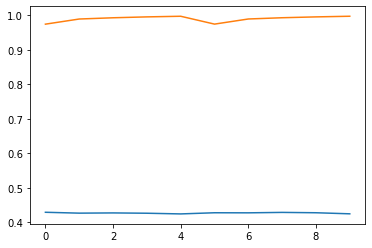

In [ ]:
# grid search

depth = [15,19,21,23,25]
estimator = [150,180]
#leaf [2,3,4]

pred = []
tr = []

for i in estimator:
    for j in depth:
        rf = RF(max_depth=j, n_estimators = i, random_state=1008, n_jobs=-1)
        rf.fit(X_resampled1, y_resampled1)
        pred1 = metrics.f1_score(y_test1,rf.predict(x_test1))
        tr1 = metrics.f1_score(y_resampled1,rf.predict(X_resampled1)) 

        rf = RF(max_depth=j, n_estimators = i, random_state=1008, n_jobs=-1)
        rf.fit(X_resampled2, y_resampled2)
        pred2 = metrics.f1_score(y_test2, rf.predict(x_test2)) 
        tr2 = metrics.f1_score(y_resampled2, rf.predict(X_resampled2)) 
        
        rf = RF(max_depth=j, n_estimators = i, random_state=1008, n_jobs=-1)
        rf.fit(X_resampled3, y_resampled3)
        pred3 = metrics.f1_score(y_test3, rf.predict(x_test3))
        tr3 = metrics.f1_score(y_resampled3, rf.predict(X_resampled3))

        pred.append(np.mean([pred1 , pred2, pred3]))
        tr.append(np.mean([tr1, tr2, tr3]))
            
plt.figure()
plt.plot(pred)
plt.plot(tr)
plt.show()
pred
# depth 21이 최적

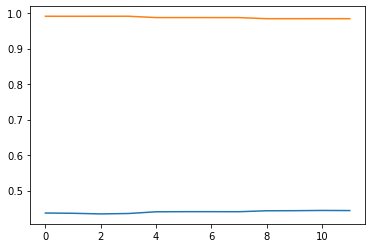

0.44388176722225475

In [ ]:
# grid search

estimator = [170,180,190,200]
leaf = [2,3,4]

pred = []
tr = []

for i in leaf:
    for j in estimator:
        rf = RF(max_depth=21, min_samples_leaf=i, n_estimators = j, random_state=1008, n_jobs=-1)
        rf.fit(X_resampled1, y_resampled1)
        pred1 = metrics.f1_score(y_test1,rf.predict(x_test1))
        tr1 = metrics.f1_score(y_resampled1,rf.predict(X_resampled1)) 

        rf = RF(max_depth=21, min_samples_leaf=i, n_estimators = j, random_state=1008, n_jobs=-1)
        rf.fit(X_resampled2, y_resampled2)
        pred2 = metrics.f1_score(y_test2, rf.predict(x_test2)) 
        tr2 = metrics.f1_score(y_resampled2, rf.predict(X_resampled2)) 
        
        rf = RF(max_depth=21, min_samples_leaf=i, n_estimators = j, random_state=1008, n_jobs=-1)
        rf.fit(X_resampled3, y_resampled3)
        pred3 = metrics.f1_score(y_test3, rf.predict(x_test3))
        tr3 = metrics.f1_score(y_resampled3, rf.predict(X_resampled3))

        pred.append(np.mean([pred1 , pred2, pred3]))
        tr.append(np.mean([tr1, tr2, tr3]))
            
plt.figure()
plt.plot(pred)
plt.plot(tr)
plt.show()

pred
# n_estimator = 190 최적

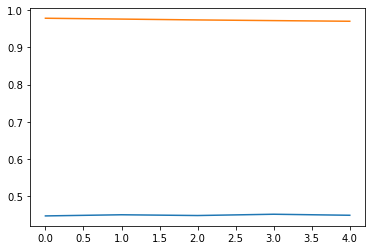

[0.44622326009130225,
 0.4493247281720363,
 0.44726599755371654,
 0.4507280591539174,
 0.4479671531536899]

In [ ]:
# grid search

leaf = [6,7,8,9,10]

pred = []
tr = []

for i in leaf:
    rf = RF(max_depth=21, min_samples_leaf=i, n_estimators = 190, random_state=1008, n_jobs=-1)
    rf.fit(X_resampled1, y_resampled1)
    pred1 = metrics.f1_score(y_test1,rf.predict(x_test1))
    tr1 = metrics.f1_score(y_resampled1,rf.predict(X_resampled1)) 

    rf = RF(max_depth=21, min_samples_leaf=i, n_estimators = 190, random_state=1008, n_jobs=-1)
    rf.fit(X_resampled2, y_resampled2)
    pred2 = metrics.f1_score(y_test2, rf.predict(x_test2)) 
    tr2 = metrics.f1_score(y_resampled2, rf.predict(X_resampled2)) 
        
    rf = RF(max_depth=21, min_samples_leaf=i, n_estimators = 190, random_state=1008, n_jobs=-1)
    rf.fit(X_resampled3, y_resampled3)
    pred3 = metrics.f1_score(y_test3, rf.predict(x_test3))
    tr3 = metrics.f1_score(y_resampled3, rf.predict(X_resampled3))

    pred.append(np.mean([pred1 , pred2, pred3]))
    tr.append(np.mean([tr1, tr2, tr3]))
            
plt.figure()
plt.plot(pred)
plt.plot(tr)
plt.show()

pred
# min_samples_leaf = 9

In [ ]:
# 최적 하이퍼파라미터 지정 및 점수

rf = RF(max_depth=21, min_samples_leaf=9, n_estimators = 190, random_state=1008, n_jobs=-1)
rf.fit(X_resampled1, y_resampled1)
pred1 = metrics.f1_score(y_test1,rf.predict(x_test1))

rf = RF(max_depth=21, min_samples_leaf=9, n_estimators = 190, random_state=1008, n_jobs=-1)
rf.fit(X_resampled2, y_resampled2)
pred2 = metrics.f1_score(y_test2, rf.predict(x_test2)) 
    
rf = RF(max_depth=21, min_samples_leaf=9, n_estimators = 190, random_state=1008, n_jobs=-1)
rf.fit(X_resampled3, y_resampled3)
pred3 = metrics.f1_score(y_test3, rf.predict(x_test3))

pred = []
pred.append(np.mean([pred1 , pred2, pred3]))
np.max(pred) # 최종점수


0.4507280591539174

#### LogisticRegression with Smote

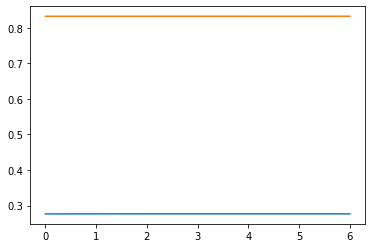

0.27661802694344406


In [ ]:
C = [0.1,1,10,20,30,50,70]
pred = []
tr = []
for i in C:
    clf = LogisticRegression(penalty = 'l2',C=i,max_iter=500, solver='saga', n_jobs=-1)
    clf.fit(X_resampled1, y_resampled1)
    pred1 = metrics.f1_score(y_test1,clf.predict(x_test1))
    tr1 = metrics.f1_score(y_resampled1,clf.predict(X_resampled1))
    
    clf = LogisticRegression(penalty = 'l2',C=i,max_iter=500, solver='saga', n_jobs=-1)
    clf.fit(X_resampled2, y_resampled2)
    pred2 = metrics.f1_score(y_test2,clf.predict(x_test2))
    tr2 = metrics.f1_score(y_resampled2,clf.predict(X_resampled2))
    
    clf = LogisticRegression(penalty = 'l2',C=i,max_iter=500, solver='saga', n_jobs=-1)
    clf.fit(X_resampled3, y_resampled3)
    pred3 = metrics.f1_score(y_test3,clf.predict(x_test3))
    tr3 = metrics.f1_score(y_resampled3,clf.predict(X_resampled3))

    pred.append(np.mean([pred1 , pred2, pred3]))
    tr.append(np.mean([tr1, tr2, tr3]))

plt.figure()
plt.plot(pred)
plt.plot(tr)
plt.show()
print(np.max(pred))

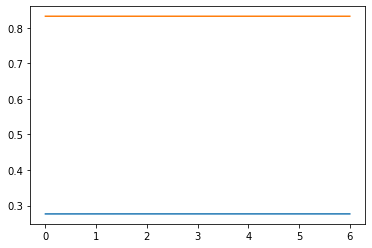

0.27661802694344406


In [ ]:
C = [0.1,1,10,20,30,50,70]
pred = []
tr = []
for i in C:
    clf = LogisticRegression(penalty = 'l1',C=i,max_iter=500, solver='saga', n_jobs=-1)
    clf.fit(X_resampled1, y_resampled1)
    pred1 = metrics.f1_score(y_test1,clf.predict(x_test1))
    tr1 = metrics.f1_score(y_resampled1,clf.predict(X_resampled1))
    
    clf = LogisticRegression(penalty = 'l1',C=i,max_iter=500, solver='saga', n_jobs=-1)
    clf.fit(X_resampled2, y_resampled2)
    pred2 = metrics.f1_score(y_test2,clf.predict(x_test2))
    tr2 = metrics.f1_score(y_resampled2,clf.predict(X_resampled2))
    
    clf = LogisticRegression(penalty = 'l1',C=i,max_iter=500, solver='saga', n_jobs=-1)
    clf.fit(X_resampled3, y_resampled3)
    pred3 = metrics.f1_score(y_test3,clf.predict(x_test3))
    tr3 = metrics.f1_score(y_resampled3,clf.predict(X_resampled3))

    pred.append(np.mean([pred1 , pred2, pred3]))
    tr.append(np.mean([tr1, tr2, tr3]))

plt.figure()
plt.plot(pred)
plt.plot(tr)
plt.show()
print(np.max(pred))

In [ ]:
pred

[0.27651331490742814,
 0.27658510013496224,
 0.27660153393683135,
 0.27661802694344406,
 0.27661802694344406,
 0.27661802694344406,
 0.27661802694344406]

#### CatBoost with Smote

### 그리드 서치 결과 선정된 최적의 하이퍼파라미터로 모델 학습

In [ ]:
cat = CatBoostClassifier(iterations=1000,depth=16, l2_leaf_reg=0.07, leaf_estimation_iterations=15,
                         cat_features = cat_cols, loss_function='Logloss', eval_metric='F1',
                           random_seed=42, metric_period=100)

cat.fit(catb_train1, y_resampled1)

0:	learn: 0.8952768	total: 5.12s	remaining: 1h 25m 17s
100:	learn: 0.9843512	total: 8m 26s	remaining: 1h 15m 9s
200:	learn: 0.9982146	total: 16m 58s	remaining: 1h 7m 27s
300:	learn: 0.9997451	total: 24m 50s	remaining: 57m 41s
400:	learn: 0.9999537	total: 32m 53s	remaining: 49m 7s
500:	learn: 0.9999923	total: 44m 15s	remaining: 44m 4s
600:	learn: 0.9999923	total: 59m 23s	remaining: 39m 25s
700:	learn: 0.9999923	total: 1h 7m 20s	remaining: 28m 45s
800:	learn: 1.0000000	total: 1h 15m 27s	remaining: 18m 46s
900:	learn: 1.0000000	total: 1h 19m 36s	remaining: 8m 45s
999:	learn: 1.0000000	total: 1h 23m 21s	remaining: 0us


In [ ]:
predict_train = cat.predict(catb_train1)
print(metrics.f1_score(y_resampled1, predict_train))
predict_test = cat.predict(catb_test1)
print(metrics.f1_score(y_test1, predict_test))

0.9999536543541734
0.4019110182143924


## 2) ClassWeight modeling

In [ ]:
# 앞서 사용한 데이터 셋 가져오기
x = x_test.copy().reset_index(drop=True)
y = pd.DataFrame(y_test.copy().reset_index(drop=True))
print(x.shape,y.shape)

(102644, 18) (102644, 1)


In [ ]:
x_train1 = x.iloc[train_idx[0],:]
x_train2 = x.iloc[train_idx[1],:]
x_train3 = x.iloc[train_idx[2],:]

y_train1 = y.iloc[train_idx[0],:]
y_train2 = y.iloc[train_idx[1],:]
y_train3 = y.iloc[train_idx[2],:]

x_test1 = x.iloc[test_idx[0],:]
x_test2 = x.iloc[test_idx[1],:]
x_test3 = x.iloc[test_idx[2],:]

y_test1 = y.iloc[test_idx[0],:]
y_test2 = y.iloc[test_idx[1],:]
y_test3 = y.iloc[test_idx[2],:]

In [ ]:
# 미리 catboost데이터 나눠두기
catb_train1 = x_train1.copy()
catb_train2 = x_train2.copy()
catb_train3 = x_train3.copy()

catb_test1 = x_test1.copy()
catb_test2 = x_test2.copy()
catb_test3 = x_test3.copy()

In [ ]:
encoder = OrdinalEncoder()

cat_cols = ['gender','employment_type','houseown_type',
            'age','work_year','rehabilitation','income_type',
            'purpose','loan_per']

for columns in cat_cols:
    encode(x_train1[columns])
for columns in cat_cols:
    encode(x_train2[columns])
for columns in cat_cols:
    encode(x_train3[columns])
for columns in cat_cols:
    encode(x_test1[columns])
for columns in cat_cols:
    encode(x_test2[columns])
for columns in cat_cols:
    encode(x_test3[columns])

### RandomForest

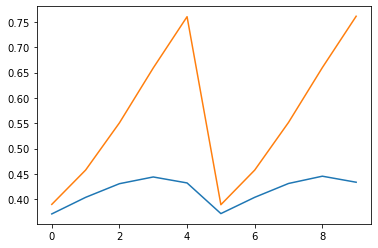

[0.37074510429612034,
 0.40348645704969915,
 0.4304967070041799,
 0.4437866002183624,
 0.4319762974886743,
 0.3713932269620746,
 0.4035522383579319,
 0.430911767152884,
 0.4453133408641556,
 0.43336108450033306]

In [ ]:
# grid search
depth = [8,10,12,14,16]
estimator = [120,160]
#leaf [2,3,4]

pred = []
tr = []

for i in estimator:
    for j in depth:
        rf = RF(max_depth=j, n_estimators = i, random_state=1008, class_weight='balanced')
        rf.fit(x_train1, y_train1)
        pred1 = metrics.f1_score(y_test1,rf.predict(x_test1))
        tr1 = metrics.f1_score(y_train1,rf.predict(x_train1)) 

        rf = RF(max_depth=j, n_estimators = i, random_state=1008, class_weight='balanced')
        rf.fit(x_train2, y_train2)
        pred2 = metrics.f1_score(y_test2, rf.predict(x_test2)) 
        tr2 = metrics.f1_score(y_train2, rf.predict(x_train2)) 
        
        rf = RF(max_depth=j, n_estimators = i, random_state=1008, class_weight='balanced')
        rf.fit(x_train3, y_train3)
        pred3 = metrics.f1_score(y_test3, rf.predict(x_test3))
        tr3 = metrics.f1_score(y_train3, rf.predict(x_train3))

        pred.append(np.mean([pred1 , pred2, pred3]))
        tr.append(np.mean([tr1, tr2, tr3]))
            
plt.figure()
plt.plot(pred)
plt.plot(tr)
plt.show()
pred
# depth=14

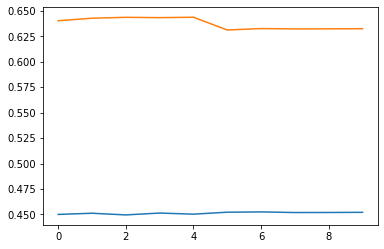

[0.4499564900034853,
 0.45111468473704397,
 0.4494694971471524,
 0.4513048788412483,
 0.4502189162000856,
 0.452137556197004,
 0.45242743697017773,
 0.45181831714590076,
 0.45185974182684774,
 0.45202475750441745]

In [ ]:
# grid search
estimator = [130,150,170,190,210]
leaf = [3,4]

pred = []
tr = []

for i in leaf:
    for j in estimator:
        rf = RF(max_depth=14, min_samples_leaf=i, class_weight='balanced',n_estimators = j, random_state=100)
        rf.fit(x_train1, y_train1)
        pred1 = metrics.f1_score(y_test1,rf.predict(x_test1))
        tr1 = metrics.f1_score(y_train1,rf.predict(x_train1)) 

        rf = RF(max_depth=14, min_samples_leaf=i, class_weight='balanced',n_estimators = j, random_state=1008)
        rf.fit(x_train2, y_train2)
        pred2 = metrics.f1_score(y_test2, rf.predict(x_test2)) 
        tr2 = metrics.f1_score(y_train2, rf.predict(x_train2)) 
        
        rf = RF(max_depth=14, min_samples_leaf=i, class_weight='balanced',n_estimators = j, random_state=1008)
        rf.fit(x_train3, y_train3)
        pred3 = metrics.f1_score(y_test3, rf.predict(x_test3))
        tr3 = metrics.f1_score(y_train3, rf.predict(x_train3))

        pred.append(np.mean([pred1 , pred2, pred3]))
        tr.append(np.mean([tr1, tr2, tr3]))
            
plt.figure()
plt.plot(pred)
plt.plot(tr)
plt.show()

pred
# n_estimator = 150 최적

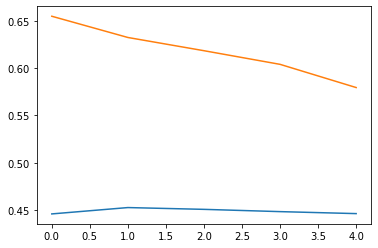

[0.4459369528295349,
 0.452650057049367,
 0.4507564213166269,
 0.44835864373213036,
 0.4462618823153423]

In [ ]:
# grid search

depth = [2,4,5,6,8]

pred = []
tr = []

for i in depth:
    rf = RF(max_depth=14, min_samples_leaf=i, n_estimators = 150,class_weight='balanced', random_state=1008)
    rf.fit(x_train1, y_train1)
    pred1 = metrics.f1_score(y_test1,rf.predict(x_test1))
    tr1 = metrics.f1_score(y_train1,rf.predict(x_train1)) 

    rf = RF(max_depth=14, min_samples_leaf=i, n_estimators = 150,class_weight='balanced', random_state=1008)
    rf.fit(x_train2, y_train2)
    pred2 = metrics.f1_score(y_test2, rf.predict(x_test2)) 
    tr2 = metrics.f1_score(y_train2, rf.predict(x_train2)) 
        
    rf = RF(max_depth=14, min_samples_leaf=i, n_estimators = 150,class_weight='balanced', random_state=1008)
    rf.fit(x_train3, y_train3)
    pred3 = metrics.f1_score(y_test3, rf.predict(x_test3))
    tr3 = metrics.f1_score(y_train3, rf.predict(x_train3))

    pred.append(np.mean([pred1 , pred2, pred3]))
    tr.append(np.mean([tr1, tr2, tr3]))
            
plt.figure()
plt.plot(pred)
plt.plot(tr)
plt.show()

pred
# min_samples_leaf = 4

In [ ]:
#최종 하이퍼파라미터
rf = RF(max_depth=14, min_samples_leaf=4, n_estimators = 150,class_weight='balanced', random_state=1008)
rf.fit(x_train1,y_train1)
predict_test1 = metrics.f1_score(y_test1, rf.predict(x_test1))
rf.fit(x_train2,y_train2)
predict_test2 = metrics.f1_score(y_test2, rf.predict(x_test2))
rf.fit(x_train3,y_train3)
predict_test3 = metrics.f1_score(y_test3, rf.predict(x_test3))
print(np.mean([predict_test1,predict_test2,predict_test3]))
print(classification_report(y_test3, rf.predict(x_test3)))

0.452650057049367
              precision    recall  f1-score   support

         0.0       0.98      0.93      0.95     32365
         1.0       0.34      0.65      0.44      1849

    accuracy                           0.91     34214
   macro avg       0.66      0.79      0.70     34214
weighted avg       0.94      0.91      0.93     34214



In [ ]:
#permutation importance

rf = RF(max_depth=14, min_samples_leaf=4, n_estimators = 150,class_weight='balanced', random_state=1008)
rf.fit(x_train1,y_train1)

perm = PermutationImportance(rf, random_state=1).fit(x_test1,y_test1)
eli5.show_weights(perm,feature_names = x_test1.columns.tolist())

Weight,Feature
0.0136 ± 0.0011,loan_limit
0.0021 ± 0.0017,rate_rank
0.0016 ± 0.0013,loan_per
0.0005 ± 0.0006,age
0.0004 ± 0.0003,work_year
0.0004 ± 0.0003,gender
0.0003 ± 0.0005,rehabilitation
0.0003 ± 0.0004,houseown_type
-0.0001 ± 0.0002,income_type
-0.0003 ± 0.0005,existing_loan_cnt


In [ ]:
feature_importance = pd.DataFrame({
    'feature': x_test1.columns,
    'importance': rf.feature_importances_
})
feature_importance

,feature,importance
0,gender,0.005478
1,yearly_income,0.032234
2,income_type,0.013646
3,employment_type,0.007385
4,houseown_type,0.008464
5,desired_amount,0.046684
6,purpose,0.010713
7,existing_loan_cnt,0.021363
8,existing_loan_amt,0.030390
9,age,0.014012


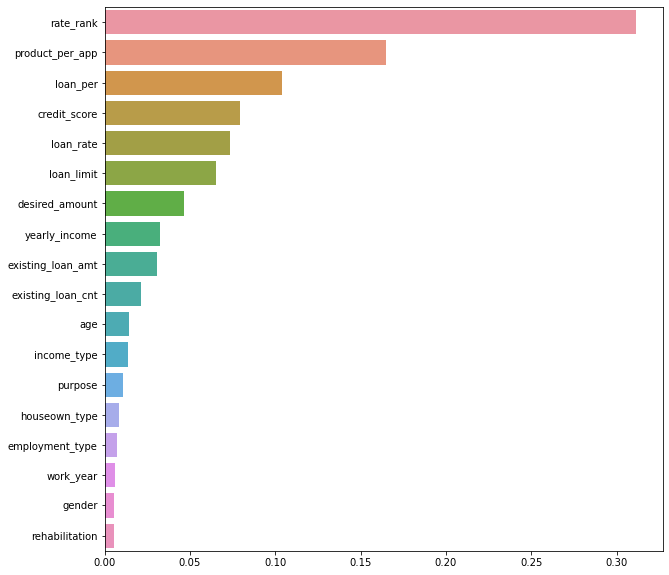

In [ ]:
ftr_importances_values = rf.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=x_test1.columns)
ftr_top = ftr_importances.sort_values(ascending=False)
 
plt.figure(figsize=(10, 10))
sns.barplot(x=ftr_top, y=ftr_top.index)
plt.show()

### Logistic

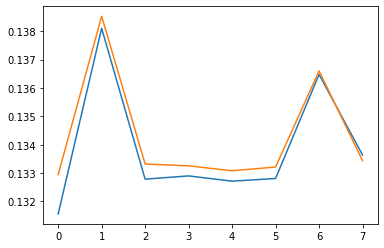

[0.1315609920759442,
 0.13810147854710977,
 0.1327859551435263,
 0.13290066169770345,
 0.1327147794541048,
 0.13280983822171724,
 0.13647577057210655,
 0.1336364767524818]

In [ ]:
C = [0.1,1,3,5,10,20,30,50]
pred = []
tr = []
for i in C:
    clf = LogisticRegression(penalty = 'l1',C=i,max_iter=1000, solver='saga', class_weight='balanced')
    clf.fit(x_train1, y_train1)
    pred1 = metrics.f1_score(np.array(y_test1),clf.predict(x_test1))
    tr1 = metrics.f1_score(y_train1,clf.predict(x_train1))
    
    clf = LogisticRegression(penalty = 'l1',C=i,max_iter=1000, solver='saga',class_weight='balanced')
    clf.fit(x_train2, y_train2)
    pred2 = metrics.f1_score(np.array(y_test2),clf.predict(x_test2))
    tr2 = metrics.f1_score(y_train2,clf.predict(x_train2))
    
    clf = LogisticRegression(penalty = 'l1',C=i,max_iter=1000, solver='saga',class_weight='balanced')
    clf.fit(x_train3, y_train3)
    pred3 = metrics.f1_score(np.array(y_test3),clf.predict(x_test3))
    tr3 = metrics.f1_score(y_train3,clf.predict(x_train3))

    pred.append(np.mean([pred1 , pred2, pred3]))
    tr.append(np.mean([tr1, tr2, tr3]))

plt.figure()
plt.plot(pred)
plt.plot(tr)
plt.show()
pred

In [ ]:
predict_train = lr_clf.predict(x_train1)
print(classification_report(y_train1, predict_train))

predict_test = lr_clf.predict(x_test1)
print(classification_report(y_test1, predict_test))

              precision    recall  f1-score   support

         0.0       0.96      0.79      0.87     64731
         1.0       0.09      0.38      0.15      3698

    accuracy                           0.77     68429
   macro avg       0.53      0.58      0.51     68429
weighted avg       0.91      0.77      0.83     68429

              precision    recall  f1-score   support

         0.0       0.96      0.79      0.86     32366
         1.0       0.10      0.40      0.16      1849

    accuracy                           0.77     34215
   macro avg       0.53      0.59      0.51     34215
weighted avg       0.91      0.77      0.83     34215



### CatBoost

In [ ]:
cat_cols = [0,2,3,4,6,9,10,11,16]

In [ ]:
#, l2_leaf_reg = ?, leaf_estimation_iterations = ?,depth = ?,task_type='GPU'
cat = CatBoostClassifier(iterations=1000,depth=16,l2_leaf_reg=0.07,leaf_estimation_iterations=15,
                           loss_function='Logloss',eval_metric='F1',cat_features = cat_cols,
                           random_seed=42,  class_weights=[0.005,0.995], metric_period=100)

cat.fit(catb_train1, y_train1)

0:	learn: 0.9841189	total: 4.95s	remaining: 1h 22m 22s
100:	learn: 0.9962494	total: 6m 38s	remaining: 59m 10s
200:	learn: 0.9985474	total: 14m 32s	remaining: 57m 47s
300:	learn: 0.9994710	total: 27m 10s	remaining: 1h 3m 5s
400:	learn: 0.9997969	total: 34m 32s	remaining: 51m 35s
500:	learn: 0.9999130	total: 40m 33s	remaining: 40m 24s
600:	learn: 0.9999402	total: 44m 20s	remaining: 29m 26s
700:	learn: 0.9999470	total: 47m 2s	remaining: 20m 3s
800:	learn: 0.9999490	total: 49m 52s	remaining: 12m 23s
900:	learn: 0.9999490	total: 52m 41s	remaining: 5m 47s
999:	learn: 0.9999490	total: 55m 25s	remaining: 0us


In [ ]:
predict_train = cat.predict(catb_train1)
print(classification_report(y_train1, predict_train))
predict_test = cat.predict(catb_test1)
print(classification_report(y_test1, predict_test))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     64731
         1.0       0.92      1.00      0.96      3698

    accuracy                           1.00     68429
   macro avg       0.96      1.00      0.98     68429
weighted avg       1.00      1.00      1.00     68429

              precision    recall  f1-score   support

         0.0       0.97      0.95      0.96     32366
         1.0       0.37      0.53      0.43      1849

    accuracy                           0.93     34215
   macro avg       0.67      0.74      0.70     34215
weighted avg       0.94      0.93      0.93     34215



### SMOTE
1) RandomForest : 0.450  
2) Logistic : 0.276  
3) Catboost : 0.401  
### Class_Weight
1) RandomForest : 0.452  
2) Logistic : 0.138   
3) Catboost : 0.43  
## 최종 모델 :  RandomForest with Class_weight

# 3. 최종 모델 선정 및 신청여부 예측

In [ ]:
#수정된 최종 제출 데이터를 기존 데이터에 결합
re_loan_result = pd.read_csv('/Users/user/Downloads/평가데이터(루키부문,퓨처스부문)_수정_221011/데이터분석분야_퓨처스부문_평가데이터.csv')
re_loan_result

,application_id,product_id,is_applied
0,4,220,NaN
1,4,191,NaN
2,8,29,NaN
3,8,159,NaN
4,8,85,NaN
...,...,...,...
3255189,2167778,258,NaN
3255190,2167791,29,NaN
3255191,2167822,149,NaN
3255192,2167822,157,NaN


In [ ]:
test = pd.merge(re_loan_result,data1.drop(['Unnamed: 0','is_applied'],axis=1),how='left',on=['application_id','product_id'])
test.head()

,application_id,product_id,is_applied,user_id,gender,insert_time,yearly_income,income_type,employment_type,houseown_type,...,work_year,rehabilitation,loanapply_insert_time,bank_id,loan_limit,loan_rate,rate_rank,product_per_app,loan_per,credit_score
0,4,220,NaN,209531,0,2022-06-20 10:24:36,26000000.0,EARNEDINCOME,정규직,기타가족소유,...,N년차,해당없음,2022-06-20 10:24:38,7,10000000.0,11.4,1,2,대출신청다수,720.0
1,4,191,NaN,209531,0,2022-06-20 10:24:36,26000000.0,EARNEDINCOME,정규직,기타가족소유,...,N년차,해당없음,2022-06-20 10:24:38,7,26000000.0,11.4,1,2,대출신청다수,720.0
2,8,29,NaN,675741,1,2022-06-02 13:10:28,9000000.0,PRIVATEBUSINESS,기타,전월세,...,N년차,해당없음,2022-06-02 13:10:29,35,5000000.0,14.5,1,3,대출안함,590.0
3,8,159,NaN,675741,1,2022-06-02 13:10:28,9000000.0,PRIVATEBUSINESS,기타,전월세,...,N년차,해당없음,2022-06-02 13:10:30,55,5000000.0,19.9,3,3,대출안함,590.0
4,8,85,NaN,675741,1,2022-06-02 13:10:28,9000000.0,PRIVATEBUSINESS,기타,전월세,...,N년차,해당없음,2022-06-02 13:10:29,30,13000000.0,15.9,2,3,대출안함,590.0


In [ ]:
x_train = train.drop(['is_applied'],axis=1)
y_train = train[['is_applied']]
x_test = test.drop(['user_id','is_applied','application_id','product_id','insert_time','loanapply_insert_time',
                   'bank_id'],axis=1)

encoder = OrdinalEncoder()

cat_cols = ['gender','employment_type','houseown_type',
            'age','work_year','rehabilitation','income_type',
            'purpose','loan_per']

for columns in cat_cols:
    encode(x_train[columns])
for columns in cat_cols:
    encode(x_test[columns])
    
x_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3255194 entries, 0 to 3255193
Data columns (total 18 columns):
 #   Column             Dtype  
---  ------             -----  
 0   gender             object 
 1   yearly_income      float64
 2   income_type        object 
 3   employment_type    object 
 4   houseown_type      object 
 5   desired_amount     float64
 6   purpose            object 
 7   existing_loan_cnt  int64  
 8   existing_loan_amt  float64
 9   age                object 
 10  work_year          object 
 11  rehabilitation     object 
 12  loan_limit         float64
 13  loan_rate          float64
 14  rate_rank          int64  
 15  product_per_app    int64  
 16  loan_per           object 
 17  credit_score       float64
dtypes: float64(6), int64(3), object(9)
memory usage: 471.9+ MB


In [ ]:
rf = RF(max_depth=14, min_samples_leaf=4, n_estimators = 150,class_weight='balanced', random_state=1008)
rf.fit(x_train, y_train)
result =  rf.predict(x_test)
result

array([1., 1., 0., ..., 0., 0., 0.])

In [ ]:
re_loan_result['is_applied']=result
re_loan_result.head()

,application_id,product_id,is_applied
0,4,220,1.0
1,4,191,1.0
2,8,29,0.0
3,8,159,0.0
4,8,85,0.0


In [ ]:
re_loan_result.isnull().sum()

application_id    0
product_id        0
is_applied        0
dtype: int64

In [ ]:
re_loan_result.to_csv('/Users/user/Downloads/데이터분석분야_퓨처스부문_빅콘치즈_평가데이터.csv')